In [1]:
# importing libraries needed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import when, min, max, col, round, lower, trim, countDistinct, count, sum, month, hour, avg, radians as spark_radians, radians
from math import radians, cos, sin, asin, sqrt, atan2
from pyspark.sql.functions import radians as spark_radians, sin as spark_sin, cos as spark_cos, atan2 as spark_atan2, sqrt as spark_sqrt, round as spark_round, col, avg, radians, sin, cos, atan2, sqrt, when, lit
from pyspark.sql import Window

from pyspark.sql.functions import sum as spark_sum, col, when

## Starting PySpark session

In [2]:
# sets logging level for py4j (used by pyspark to communicate with JVM, Java Virtual Machine)

import logging
logging.getLogger("py4j").setLevel(logging.INFO)

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("EDA") \
        .config("spark.ui.showConsoleProgress", "false") \
        .config("spark.local.dir", "C:/temp/spark") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

# Set logging level
spark.sparkContext.setLogLevel("ERROR")

spark

In [4]:
# Load cleaned datasets and functions created

# Add src to the Python path if needed
import sys
sys.path.append("../raw_functions")

from raw_functions.delivery_time import time_taken_to_deliver, flag_delivery_speed_relative
from raw_functions.distance import add_order_delivery_distance
from raw_functions.installment_flagging import add_high_installment_flag
from raw_functions.product_category import get_category_in_english, group_categories_by_sales_with_ohe
from raw_functions.repeat_buyers import finding_repeat_buyers
from raw_functions.final_dataset import build_final_dataset

df_orders           = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_orders.csv", header=True)
df_customers        = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_customers.csv", header=True)
df_order_items      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_items.csv", header=True)
df_products         = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_products.csv", header=True)
df_order_payments   = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_order_payments.csv", header=True)
df_sellers          = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_seller.csv", header=True)
df_order_reviews    = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_reviews.csv", header=True)
df_geolocation      = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/cleaned_geolocation.csv", header=True)
df_product_category = spark.read.option('header', 'true').option('inferSchema', 'true').csv("raw_functions/cleaned_data/product_category_name_translation.csv", header=True)

print("All done!")

All done!


In [5]:
df_order_items.printSchema()
df_orders.printSchema()
df_order_reviews.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- - shipping_limit_date: timestamp (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_c

## Introduction to EDA

Objectives for this EDA:

1. Understand and doing basic cleaning on the datasets given
2. Distribution of data and relationship
3. Customer Behaviour Analysis
4. Payment analysis
5. Delivery pattern
6. Review score
7. Product category

Final EDA Goal:
To prepare, clean, insightful dataset with features that will be helpful in helping the model to find repeat buyers.

### 1. Understanding and doing basic cleaning on datasets

In [ ]:
##get rid of non valid zipcodes that are not in in 5 letter
zip_regex = r"^\d{5}$"
invalid_zips= df_customers.filter(
    (~col("customer_zip_code_prefix").rlike(zip_regex)) |
    col("customer_zip_code_prefix").isNull() |
    col("customer_city").isNull() |
    col("customer_state").isNull()
)
cleaned_customer = df_customers.subtract(invalid_zips)
cleaned_customer_pd = cleaned_customer.toPandas()

In [ ]:
##get rid missing
null_rows =  df_geolocation.filter(
    col("geolocation_zip_code_prefix").isNull() |
    col("geolocation_lat").isNull() |
    col("geolocation_lng").isNull() |
    col("geolocation_city").isNull() |
    col("geolocation_state").isNull())
null_rows.show()
cleaned_geolocation = df_geolocation.subtract(null_rows)
# external source and compare with given dataset 
ref_cities = spark.read.option('header', 'true').csv('/content/cities.csv')
brazil = ref_cities.filter(col("country_code")=="BR")
cleaned_geolocation = cleaned_geolocation.withColumn("city", lower(col("geolocation_city"))) \
               .withColumn("state", upper(col("geolocation_state")))

joined_df = cleaned_geolocation.join(
    brazil,
    (cleaned_geolocation.city==brazil.city) & (cleaned_geolocation.state == brazil.state),
    how= "inner"
)

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
  return geodesic((lat1, lon1), (lat2, lon2)).km
distance_udf = udf(calculate_distance, DoubleType())
joined_df = joined_df.withColumn(
    "distance_km",
    distance_udf(
        col("geolocation_lat"), col("geolocation_lng"),
        col("latitude"), col("longitude")
    )
)

In [ ]:
#if the distance exceeds 10km from the accurate, remove it
wrong_geo = joined_df.filter(col("distance_km") > 10)
very_clean_geo = joined_df.subtract(wrong_geo).drop("city","name", "state","country_id","country_code","wikiDataId")

In [ ]:
df_orders = df_orders.withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date")) \
                     .withColumn("order_approved_at", to_timestamp("order_approved_at"))

df_orders = df_orders.na.drop(subset=["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"])
# check if the delivery date is before the order approval
clean_orders = df_orders.filter(
    (col("order_delivered_customer_date") >= col("order_approved_at"))
)
clean_orders_pd = clean_orders.toPandas()

In [ ]:
#give a standard format for the timestamps and review message in case of wrong formats are found in respective columns
timestamp_pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"
review_message_pattern = r"[A-Za-z]{2,}.*[ \.,!?;:]+.*"
#filter out the information with invalid  formats
clean_reviews = df_order_reviews.filter(
    (~col("review_id").rlike(timestamp_pattern)) &
    (~col("order_id").rlike(timestamp_pattern)) &
    (~col("review_score").rlike(timestamp_pattern)) &
    (~col("review_id").rlike(review_message_pattern)) &
    (~col("order_id").rlike(review_message_pattern)) &
    (~col("review_score").rlike(review_message_pattern)) &
    (~col("review_answer_timestamp").rlike(review_message_pattern)) &
    col("review_answer_timestamp").isNotNull()
)

In [ ]:
#filter out reviews that not missing invalid information
clean_reviews = clean_reviews.filter(
    col("review_id").isNotNull() &
    col("order_id").isNotNull() &
    col("review_comment_message").isNotNull() &
    col("review_creation_date").isNotNull()
)

In [ ]:
#check if the review scores are in the right format or 1 to 5
clean_reviews = clean_reviews.filter(col("review_score").isin([1, 2, 3, 4, 5]))

In [ ]:
#filter out if the review answers are given before the review creation data

clean_reviews = clean_reviews.withColumn("review_creation_date", to_timestamp("review_creation_date")) \
                             .withColumn("review_answer_timestamp", to_timestamp("review_answer_timestamp")) \
                             .filter(col("review_answer_timestamp") >= col("review_creation_date"))

In [ ]:
#Took out review_comment_title as majority 
clean_reviews = clean_reviews.drop("review_comment_title")
order = clean_orders.select("order_id", "order_delivered_customer_date")
order = order.withColumn("order_delivered_customer_date", to_date(col("order_delivered_customer_date")))

In [ ]:
review = clean_reviews.select("order_id", "review_creation_date")
review = review.withColumn("review_creation_date", to_date(col("review_creation_date")))

In [ ]:
review = clean_reviews.select("order_id", "review_creation_date")
review = review.withColumn("review_creation_date", to_date(col("review_creation_date")))

In [ ]:
# check whether the review creation dates is before the delivery date
merged_df = review.join(order, on="order_id", how="inner")
inconsistent_reviews = merged_df.filter(col("review_creation_date") < col("order_delivered_customer_date"))

In [ ]:
#remove the rows of data that has the the reviews before the deliver
new_cleaned_reviews = clean_reviews.join(inconsistent_reviews.select("order_id"), on="order_id", how="left_anti")

In [ ]:
# check whether if there are no payment installments
clean_order_payment= df_order_payments.filter(col("payment_installments")==0)
clean_order_payment= df_order_payments.filter(col("payment_installments")!=0)
#check for null or missing values
empty_order_payment = clean_order_payment.filter(
    col("order_id").isNull()|
    col("payment_sequential").isNull()|
    col("payment_type").isNull()|
    col("payment_installments").isNull()|
    col("payment_value").isNull()
)
# check for missing data
null_payment_value = clean_order_payment.filter(col("payment_value")==0.00)

In [ ]:
#remove empty rows
clean_order_payment = clean_order_payment.subtract(empty_order_payment)

In [ ]:
#remove missing values
clean_order_payment = clean_order_payment.subtract(null_payment_value)

In [ ]:
payment = clean_order_payment.groupBy("order_id","payment_type","payment_sequential","payment_installments").count()
payment_without_undefined = payment.filter(col("payment_type") !="not_defined")
payment_without_undefined.groupBy("payment_type").count().show()
clean_payment =payment_without_undefined

In [ ]:
#check for missing seller information
missing_seller = df_sellers.filter(
  col("seller_id").isNull() |
  col("seller_zip_code_prefix").isNull() |
  col("seller_city").isNull() |
  col("seller_state").isNull()
)

In [ ]:
clean_seller = df_sellers

In [ ]:

# check for missing values in the orderlist
missing_order_items = df_order_items.filter(
    col("order_id").isNull() |
    col("order_item_id").isNull() |
    col("product_id").isNull()|
    col("shipping_limit_date").isNull()|
    col("price").isNull()|
    col("freight_value").isNull()
)
#remove missing data from order list
clean_order_items = df_order_items.subtract(missing_order_items)

In [ ]:
#check if the cleaned order items is correct
clean_order_items.filter(col("price") == 0.00).show()

In [ ]:
#filter out if the product measurements are invalid
invalid_product_measurements= df_products.filter(
    (col("product_weight_g")<=0) | (col("product_weight_g").isNull()) |
    (col("product_length_cm")<=0) | (col("product_length_cm").isNull())|
    (col("product_height_cm") <=0)| (col("product_height_cm").isNull())|
    (col("product_width_cm") <=0)| (col("product_width_cm").isNull())
)
invalid_product_measurements.show()

In [ ]:
#check for missing data
missing_categories= df_products.filter(
    col("product_category_name").isNull()
)
missing_categories.show()

In [ ]:
#check for missing data
missing_id = df_products.filter(col("product_id").isNull())

In [ ]:
#remove the missing and invalid data
clean_products = df_products.subtract(invalid_product_measurements).subtract(missing_categories)

### 2. Distribution of data and relationship

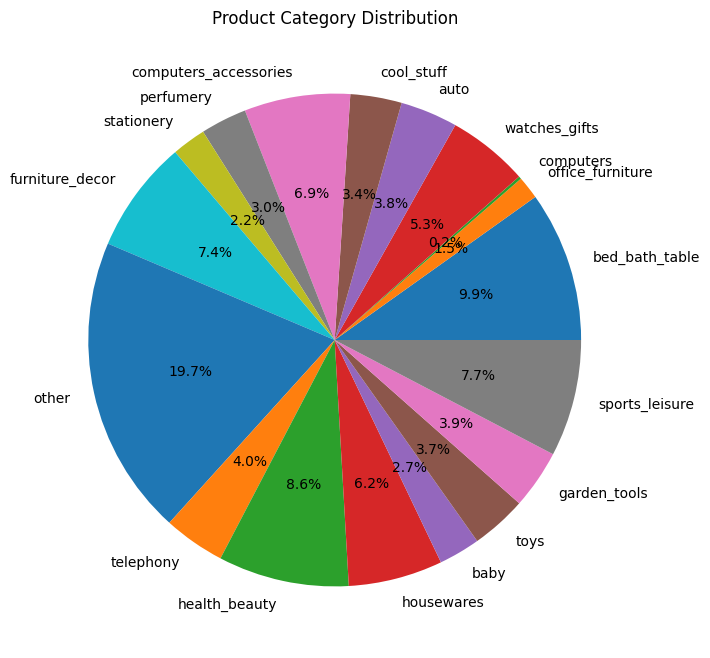

In [16]:
# most common roducts
df_category_price = get_category_in_english(df_order_items, df_products, df_product_category)
df_ohe = group_categories_by_sales_with_ohe(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8)
df_grouped_counts_pd = df_ohe.groupBy("category_grouped").count().toPandas()

# Now, plot the Pandas DataFrame which has the 'count' column
df_grouped_counts_pd.set_index("category_grouped").plot.pie(y="count", autopct='%1.1f%%', figsize=(25, 8)).legend().remove()
plt.ylabel("")
plt.title("Product Category Distribution")
plt.show()

### 3. Customer Behaviour Analysis

#### Preference of repeat buyers 

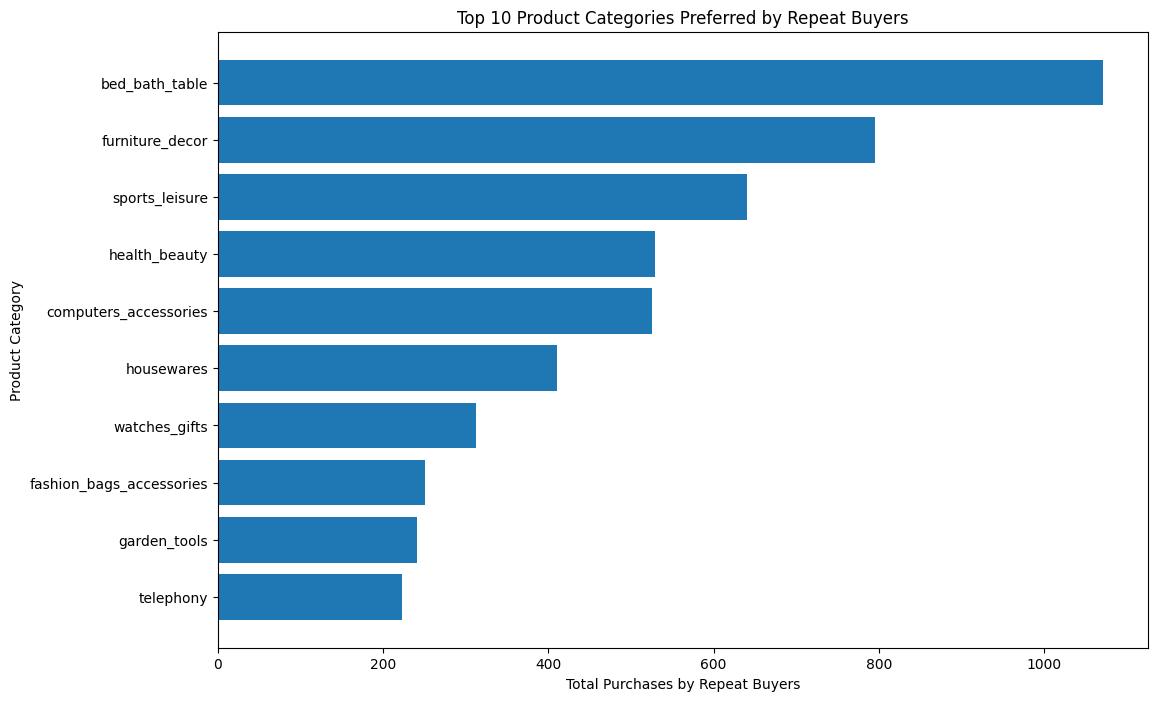

In [9]:
from pyspark.sql.functions import col

repeat_category_counts = repeat_items.groupBy("customer_id", "product_category_name") \
    .agg(count("order_id").alias("num_purchases")) \
    .orderBy("customer_id", "num_purchases", ascending=False)

category_popularity = repeat_category_counts.groupBy("product_category_name") \
    .agg({"num_purchases": "sum"}) \
    .withColumnRenamed("sum(num_purchases)", "total_purchases") \
    .orderBy("total_purchases", ascending=False)

category_popularity_pd = category_popularity.toPandas()

# Join to get English category names
category_with_english = category_popularity.join(
    df_product_category.select("product_category_name", "product_category_name_english"),
    on="product_category_name",
    how="left"
)

# Select needed columns and drop null English names if any
category_with_english = category_with_english.filter(col("product_category_name_english").isNotNull())

# Order by total purchases and take top 10
top_10_categories = category_with_english.orderBy(col("total_purchases").desc()).limit(10)

# Convert to Pandas for plotting
top_10_pd = top_10_categories.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(top_10_pd['product_category_name_english'], top_10_pd['total_purchases'])
plt.xlabel("Total Purchases by Repeat Buyers")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories Preferred by Repeat Buyers")
plt.gca().invert_yaxis()  # Highest on top
plt.show()


#### Time between orders for repeat buyers

In [14]:
from pyspark.sql.functions import col, lag, datediff, when
from pyspark.sql.window import Window

def add_repeat_order_gaps(df_orders, df_customers, customer_order_counts):
    """
    For repeat buyers, calculate time between current order and previous order.
    Sets null gaps to 1 (for models that only accept integers).

    Parameters:
        df_orders: orders DataFrame with order_id, customer_id, order_purchase_timestamp
        df_customers: customers DataFrame with customer_id and customer_unique_id
        customer_order_counts: output from finding_repeat_buyers()

    Returns:
        DataFrame with:
        - customer_unique_id
        - order_id
        - order_purchase_timestamp
        - prev_order_date
        - days_since_last_order (int, with null → 1)
        - is_first_order (1 if null before, else 0)
    """

    # Step 1: Join orders with customer_unique_id
    df_joined = df_orders.join(df_customers, on="customer_id", how="inner")

    # Step 2: Add repeat buyer flag
    df_repeat_flag = df_joined.join(
        customer_order_counts.select("customer_unique_id", "is_repeat_buyer"),
        on="customer_unique_id", how="left"
    )

    # Step 3: Filter to repeat buyers
    df_repeat_only = df_repeat_flag.filter(col("is_repeat_buyer") == 1)

    # Step 4: Define window for previous order
    window_spec = Window.partitionBy("customer_unique_id").orderBy("order_purchase_timestamp")

    # Step 5: Add previous date and calculate gap
    df_with_gaps = df_repeat_only.withColumn(
        "prev_order_date", lag("order_purchase_timestamp").over(window_spec)
    ).withColumn(
        "raw_days_since_last_order",
        datediff("order_purchase_timestamp", "prev_order_date")
    )

    # Step 6: Handle nulls → 1 and add is_first_order flag
    df_with_flags = df_with_gaps.withColumn(
        "days_since_last_order",
        when(col("raw_days_since_last_order").isNull(), -1).otherwise(col("raw_days_since_last_order"))
    )
    return df_with_flags, df_with_gaps

In [10]:
customer_order_counts = finding_repeat_buyers(df_orders, df_customers, df_order_items)
df_with_flags = add_repeat_order_gaps(df_orders, df_customers, customer_order_counts).select(
        "customer_unique_id",
        "order_id",
        "order_purchase_timestamp",
        "prev_order_date",
        "days_since_last_order",
    )
df_with_flags.show(5)

+--------------------+--------------------+------------------------+-------------------+---------------------+
|  customer_unique_id|            order_id|order_purchase_timestamp|    prev_order_date|days_since_last_order|
+--------------------+--------------------+------------------------+-------------------+---------------------+
|004288347e5e88a27...|a61d617fbe5bd006e...|     2017-07-27 22:13:03|               null|                   -1|
|004288347e5e88a27...|08204559bebd39e09...|     2018-01-14 15:36:54|2017-07-27 22:13:03|                  171|
|00a39521eb40f7012...|7d32c87acba91ed87...|     2018-05-24 04:14:21|               null|                   -1|
|00a39521eb40f7012...|cea3e6c11eb60acb9...|     2018-06-03 18:12:57|2018-05-24 04:14:21|                   10|
|012452d40dafae4df...|ce2b4f2836d78829e...|     2017-06-19 06:46:42|               null|                   -1|
+--------------------+--------------------+------------------------+-------------------+---------------------+
o

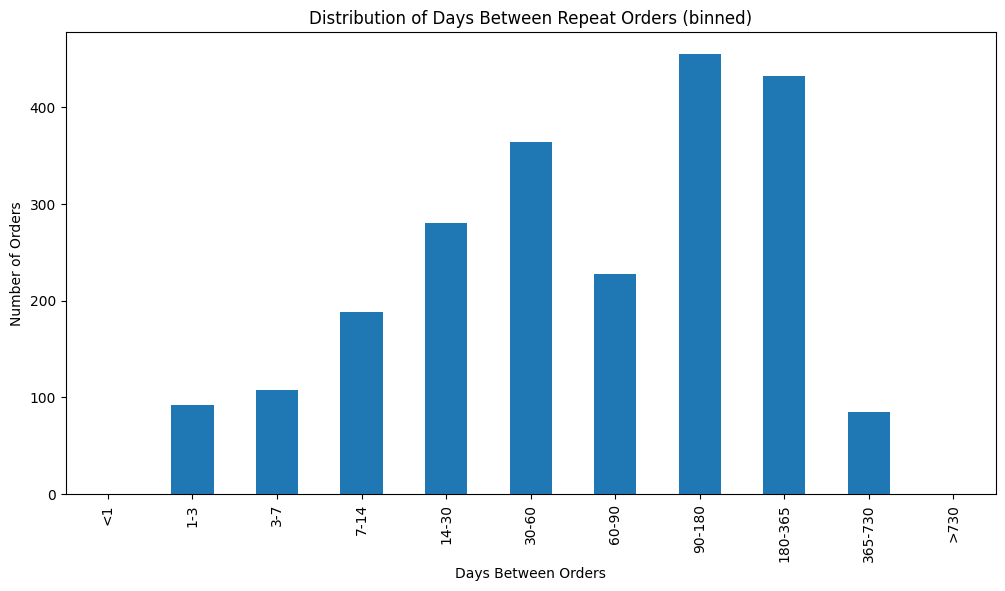

In [11]:
bins = [0, 1, 3, 7, 14, 30, 60, 90, 180, 365, 730, 10000]
labels = ['<1', '1-3', '3-7', '7-14', '14-30', '30-60', '60-90', '90-180', '180-365', '365-730', '>730']

non_first_orders = df_with_flags.filter("days_since_last_order > 0").select("days_since_last_order").toPandas()

non_first_orders['bins'] = pd.cut(non_first_orders['days_since_last_order'], bins=bins, labels=labels, right=False)

binned_counts = non_first_orders['bins'].value_counts().sort_index()

plt.figure(figsize=(12,6))
binned_counts.plot(kind='bar')
plt.xlabel('Days Between Orders')
plt.ylabel('Number of Orders')
plt.title('Distribution of Days Between Repeat Orders (binned)')
plt.show()


#### Categorising delivery speed into fast, normal, slow

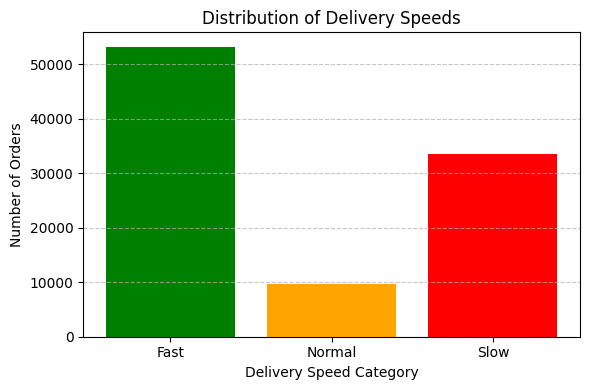

In [26]:
from pyspark.sql.functions import count

df_time = time_taken_to_deliver(df_orders)

df_flagged_speed = flag_delivery_speed_relative(df_time, delivery_time_col="delivered_in_days")

df_speed_dist = df_flagged_speed.groupBy("delivery_speed_flag").agg(count("*").alias("num_orders"))

pdf_speed_dist = df_speed_dist.toPandas()

import matplotlib.pyplot as plt

# Map flag numbers to labels
label_map = {1: "Fast", 2: "Normal", 3: "Slow"}
pdf_speed_dist["label"] = pdf_speed_dist["delivery_speed_flag"].map(label_map)

# Sort for nicer display
pdf_speed_dist = pdf_speed_dist.sort_values("delivery_speed_flag")

# Plot
plt.figure(figsize=(6,4))
plt.bar(pdf_speed_dist["label"], pdf_speed_dist["num_orders"], color=["green", "orange", "red"])
plt.title("Distribution of Delivery Speeds")
plt.xlabel("Delivery Speed Category")
plt.ylabel("Number of Orders")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


#### Does delivery timing affect review score

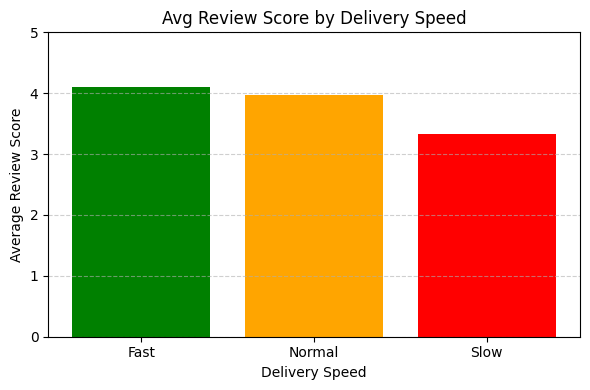

In [29]:
df_speed_review = df_flagged_speed.join(df_order_reviews.select("order_id", "review_score"), on="order_id", how="inner")

from pyspark.sql.functions import avg

df_speed_avg_review = df_speed_review.groupBy("delivery_speed_flag") \
    .agg(avg("review_score").alias("avg_review_score")) \
    .orderBy("delivery_speed_flag")

pdf_avg_review = df_speed_avg_review.toPandas()

# Map numbers to labels
label_map = {1: "Fast", 2: "Normal", 3: "Slow"}
pdf_avg_review["label"] = pdf_avg_review["delivery_speed_flag"].map(label_map)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(pdf_avg_review["label"], pdf_avg_review["avg_review_score"], color=["green", "orange", "red"])
plt.title("Avg Review Score by Delivery Speed")
plt.xlabel("Delivery Speed")
plt.ylabel("Average Review Score")
plt.ylim(0, 5)  # Because review scores go from 1–5
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


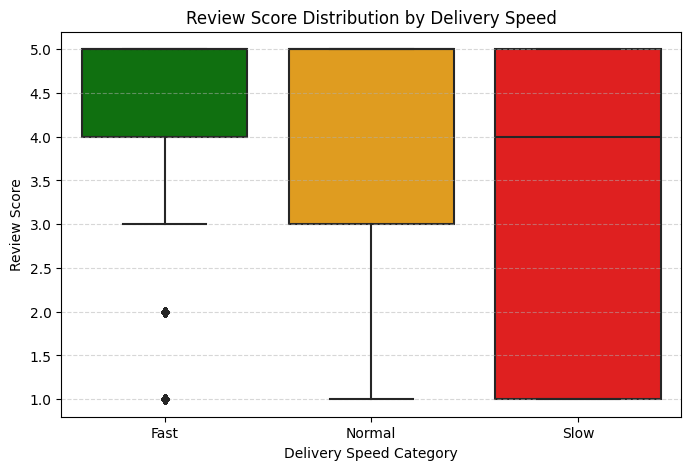

In [31]:
pdf_all = df_speed_review.toPandas()
pdf_all["label"] = pdf_all["delivery_speed_flag"].map({1: "Fast", 2: "Normal", 3: "Slow"})

import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=pdf_all, x="label", y="review_score", palette={"Fast":"green", "Normal":"orange", "Slow":"red"}, order=["Fast", "Normal", "Slow"])
plt.title("Review Score Distribution by Delivery Speed")
plt.xlabel("Delivery Speed Category")
plt.ylabel("Review Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

#### Orders purchased by hour of the day

root
 |-- order_id: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- time_of_purchase: integer (nullable = true)
 |-- month_of_purchase: integer (nullable = true)
 |-- delivered_in_days: double (nullable = true)



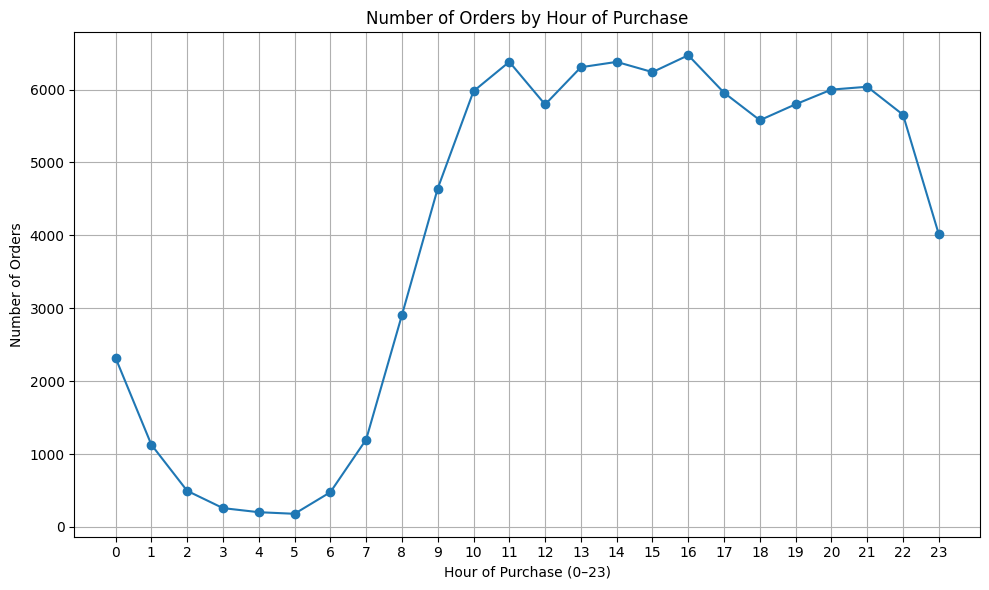

In [33]:
df_time = time_taken_to_deliver(df_orders)

df_time.printSchema()

from pyspark.sql.functions import to_timestamp, hour

df_time_clean = df_time \
    .withColumn("order_purchase_timestamp", to_timestamp("order_purchase_timestamp")) \
    .withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date")) \
    .withColumn("time_of_purchase", hour("order_purchase_timestamp")) \
    .select("time_of_purchase") \
    .filter("time_of_purchase IS NOT NULL")

delivery_pd = df_time_clean.toPandas()

orders_by_hour = delivery_pd.groupby('time_of_purchase').size().reset_index(name='num_orders')

plt.figure(figsize=(10,6))
plt.plot(orders_by_hour['time_of_purchase'], orders_by_hour['num_orders'], marker='o', linestyle='-')
plt.title("Number of Orders by Hour of Purchase")
plt.xlabel("Hour of Purchase (0–23)")
plt.ylabel("Number of Orders")
plt.xticks(range(0, 24))  # make sure all 24 hours show
plt.grid(True)
plt.tight_layout()

In [ ]:
plt.savefig("images/Review_Score_Distribution_by_Delivery_Speed.png")

### 4. Payment analysis

#### No. of repeat buyers who used vouchers

In [34]:
repeat_buyers = finding_repeat_buyers(df_orders, df_customers, df_order_items)

voucher_users = df_order_payments.filter(col("payment_type") == "voucher") \
    .select("order_id").distinct()

voucher_customers = df_orders.join(voucher_users, on="order_id") \
    .select("customer_id").distinct()

voucher_behavior = df_customers.join(voucher_customers, on="customer_id", how="inner") \
    .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id", how="left")

voucher_behavior.groupBy("is_repeat_buyer").count().show()


+---------------+-----+
|is_repeat_buyer|count|
+---------------+-----+
|              1|  308|
|              0| 3369|
+---------------+-----+



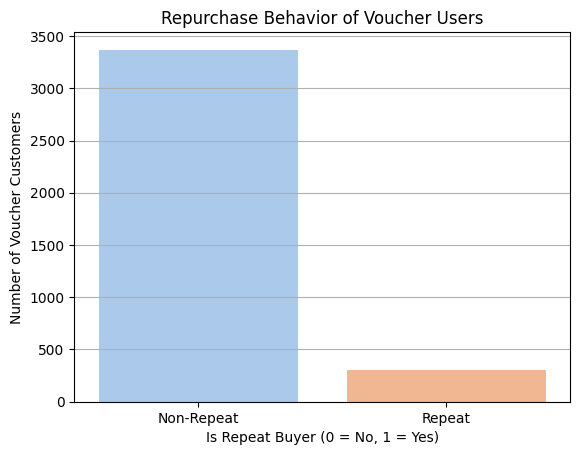

In [35]:
voucher_behavior_pd = voucher_behavior.groupBy("is_repeat_buyer").count().toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Replace nulls in case some customers weren't matched in repeat_buyers
voucher_behavior_pd['is_repeat_buyer'] = voucher_behavior_pd['is_repeat_buyer'].fillna(0).astype(int)
voucher_behavior_pd = voucher_behavior_pd.sort_values("is_repeat_buyer")

sns.barplot(data=voucher_behavior_pd, x="is_repeat_buyer", y="count", palette="pastel")
plt.title("Repurchase Behavior of Voucher Users")
plt.xlabel("Is Repeat Buyer (0 = No, 1 = Yes)")
plt.ylabel("Number of Voucher Customers")
plt.xticks([0, 1], ["Non-Repeat", "Repeat"])
plt.grid(True, axis='y')
plt.show()

#### Relationship between high installments and low repurchases

In [ ]:
df_installments = add_high_installment_flag(df_order_payments)

payment_behavior = df_installments.join(df_orders, on="order_id") \
    .join(df_customers.select("customer_id", "customer_unique_id"), on="customer_id") \
    .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id")

payment_behavior.groupBy("high_installment_flag", "is_repeat_buyer").count().show()

from pyspark.sql.functions import count, sum

payment_behavior.groupBy("high_installment_flag").agg(
    count("*").alias("total"),
    sum("is_repeat_buyer").alias("num_repeat_buyers")
).withColumn("repurchase_rate", col("num_repeat_buyers") / col("total")).show()


+---------------------+---------------+-----+
|high_installment_flag|is_repeat_buyer|count|
+---------------------+---------------+-----+
|                    1|              0|63171|
|                    1|              1| 4454|
|                    0|              0|31232|
|                    0|              1| 1812|
+---------------------+---------------+-----+

+---------------------+-----+-----------------+-------------------+
|high_installment_flag|total|num_repeat_buyers|    repurchase_rate|
+---------------------+-----+-----------------+-------------------+
|                    1|67625|             4454|0.06586321626617375|
|                    0|33044|             1812|0.05483597627405883|
+---------------------+-----+-----------------+-------------------+



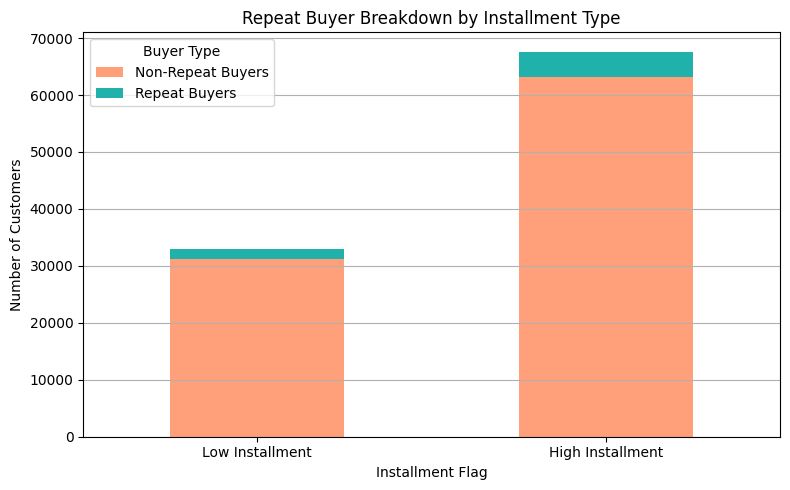

In [31]:
installment_behavior_pd = payment_behavior.groupBy("high_installment_flag", "is_repeat_buyer").count().toPandas()

installment_pivot = installment_behavior_pd.pivot(
    index="high_installment_flag", columns="is_repeat_buyer", values="count"
).fillna(0)

installment_pivot.columns = ['Non-Repeat Buyers', 'Repeat Buyers']
installment_pivot.index = ['Low Installment', 'High Installment']

installment_pivot.plot(kind="bar", stacked=True, color=["#FFA07A", "#20B2AA"], figsize=(8, 5))
plt.title("Repeat Buyer Breakdown by Installment Type")
plt.ylabel("Number of Customers")
plt.xlabel("Installment Flag")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(title="Buyer Type")
plt.tight_layout()
plt.show()


### 5. Delivery pattern

In [ ]:
# How long does delivery take?
# Will long delivery duration cause bad reviews or lower chances of repeat orders?
# Distance between customer and seller

### 6. Review score

#### Are review scores linked to repeat purchases?

In [71]:
from pyspark.sql.functions import col, avg

# Join reviews with orders and customers (assuming you have df_reviews with order_id, review_score)
df_reviews_with_customers = df_order_reviews.join(df_orders.select("order_id", "customer_id"), on="order_id") \
                                     .join(df_customers.select("customer_id", "customer_unique_id"), on="customer_id") \
                                     .join(repeat_buyers.select("customer_unique_id", "is_repeat_buyer"), on="customer_unique_id")

# Calculate average review score per customer
avg_scores = df_reviews_with_customers.groupBy("customer_unique_id", "is_repeat_buyer") \
                                     .agg(avg("review_score").alias("avg_review_score"))

# Convert to pandas for plotting
avg_scores_pd = avg_scores.toPandas()


c:\Users\jiawe\OneDrive\Documents\GitHub\309Project\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


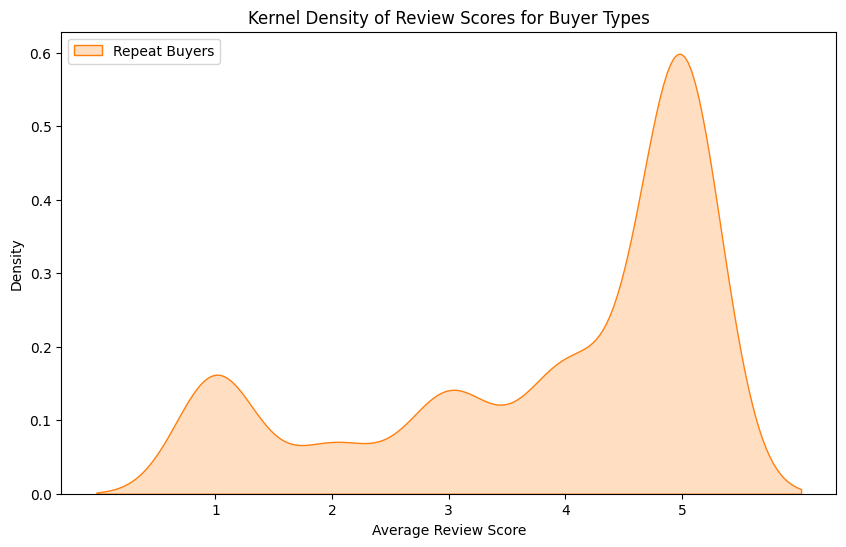

In [75]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=avg_scores_pd[avg_scores_pd['is_repeat_buyer'] == 0], x='avg_review_score', label='Non-Repeat Buyers', fill=True)
sns.kdeplot(data=avg_scores_pd[avg_scores_pd['is_repeat_buyer'] == 1], x='avg_review_score', label='Repeat Buyers', fill=True)
plt.xlabel('Average Review Score')
plt.xticks(range(1, 6))
plt.title('Kernel Density of Review Scores for Buyer Types')
plt.legend()
plt.show()


### 7. Product category

#### product categories are the most popular based on the amount of sales

In [77]:
from pyspark.sql.functions import round

def get_top_category_sales(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8):
    # Step 1: Calculate total sales per category
    sales_per_category = df_category_price.groupBy(category_col) \
        .agg(spark_sum(value_col).alias("total_sales"))

    # Step 2: Calculate total overall sales (scalar)
    total_sales = df_category_price.agg(spark_sum(value_col).alias("overall_total")).collect()[0]["overall_total"]

    # Step 3: Calculate percent and cumulative percent
    window_spec = Window.orderBy(col("total_sales").desc()).rowsBetween(Window.unboundedPreceding, 0)

    sales_enriched = sales_per_category \
        .withColumn("category_sales_percent", col("total_sales") / total_sales) \
        .withColumn("cumulative_pct", spark_sum("category_sales_percent").over(window_spec))

    # Step 4: Extract top categories within threshold
    top_categories = sales_enriched.filter(col("cumulative_pct") <= threshold) \
        .orderBy(col("total_sales").desc()) \
        .select(
            col(category_col),
            round(col("total_sales"), 2).alias("total_sales"),
            (col("category_sales_percent") * 100).alias("sales_percent"),
            (col("cumulative_pct") * 100).alias("cumulative_percent")
        )

    return top_categories

df_category_price = get_category_in_english(df_order_items, df_products, df_product_category)
top_cats_df = get_top_category_sales(df_category_price, category_col="product_category_name_english", value_col="price", threshold=0.8)
top_cats_df.show(truncate=False)


+-----------------------------+-----------+------------------+------------------+
|product_category_name_english|total_sales|sales_percent     |cumulative_percent|
+-----------------------------+-----------+------------------+------------------+
|health_beauty                |1258681.34 |9.260699940209122 |9.260699940209122 |
|watches_gifts                |1205005.68 |8.86578331949174  |18.126483259700862|
|bed_bath_table               |1036039.18 |7.622618741833781 |25.74910200153464 |
|sports_leisure               |988048.97  |7.2695326025908145|33.01863460412545 |
|computers_accessories        |911954.32  |6.709669118235596 |39.72830372236105 |
|furniture_decor              |729762.49  |5.369199679650266 |45.09750340201131 |
|cool_stuff                   |635290.85  |4.67412819245435  |49.77163159446567 |
|housewares                   |632248.66  |4.651745395589282 |54.42337699005495 |
|auto                         |592720.11  |4.3609155969830775|58.784292587038024|
|garden_tools   

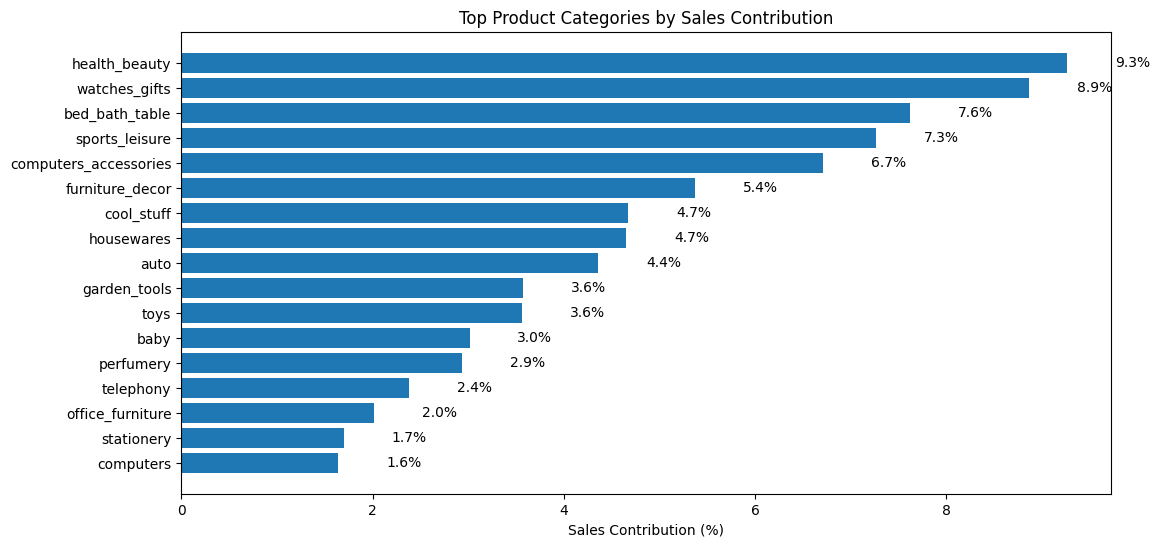

In [79]:
import matplotlib.pyplot as plt

top_cats_pd = top_cats_df.toPandas()

plt.figure(figsize=(12, 6))
bars = plt.barh(top_cats_pd['product_category_name_english'], top_cats_pd['sales_percent'])

plt.xlabel("Sales Contribution (%)")
plt.title("Top Product Categories by Sales Contribution")
plt.gca().invert_yaxis()  # Largest on top

# Add labels on the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center')

plt.show()


## Final dataset

In [5]:
final_df = build_final_dataset(
    df_order_items, df_products, df_product_category, df_orders,
    df_customers, df_sellers, df_order_payments, df_geolocation, df_order_reviews
)

final_df.select('time_of_purchase', 'month_of_purchase','delivery_speed_flag','delivery_distance_in_km', 'high_installment_flag','used_voucher','is_repeat_buyer','num_orders', 'review_score')

DataFrame[time_of_purchase: int, month_of_purchase: int, delivery_speed_flag: int, delivery_distance_in_km: double, high_installment_flag: int, used_voucher: int, is_repeat_buyer: int, num_orders: bigint, review_score: int]

In [6]:
final_df.filter(final_df.delivered_in_days.isNull()).show()

+--------+------------------+-----------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+----------+------------+
|order_id|customer_unique_id|customer_id|delivered_in_days|time_of_purchase|month_of_purchase|delivery_speed_flag|delivery_distance_in_km|installment_value|high_installment_flag|used_voucher|is_repeat_buyer|num_orders|total_purchase_value|category_grouped_ohe|product_id|review_score|
+--------+------------------+-----------+-----------------+----------------+-----------------+-------------------+-----------------------+-----------------+---------------------+------------+---------------+----------+--------------------+--------------------+----------+------------+
+--------+------------------+-----------+-----------------+----------------+-----------------+-------------------+-----------------------+-------

### Feature Correalation

In [7]:
features_to_keep = [
    "delivered_in_days", "delivery_speed_flag",
    "delivery_distance_in_km", "installment_value", "high_installment_flag", "used_voucher",
    "is_repeat_buyer", "num_orders", "total_purchase_value", "review_score"
]

# Convert one-hot encoded vector to individual columns if needed
from pyspark.ml.functions import vector_to_array

final_df_cleaned = final_df.select(
    features_to_keep,
)


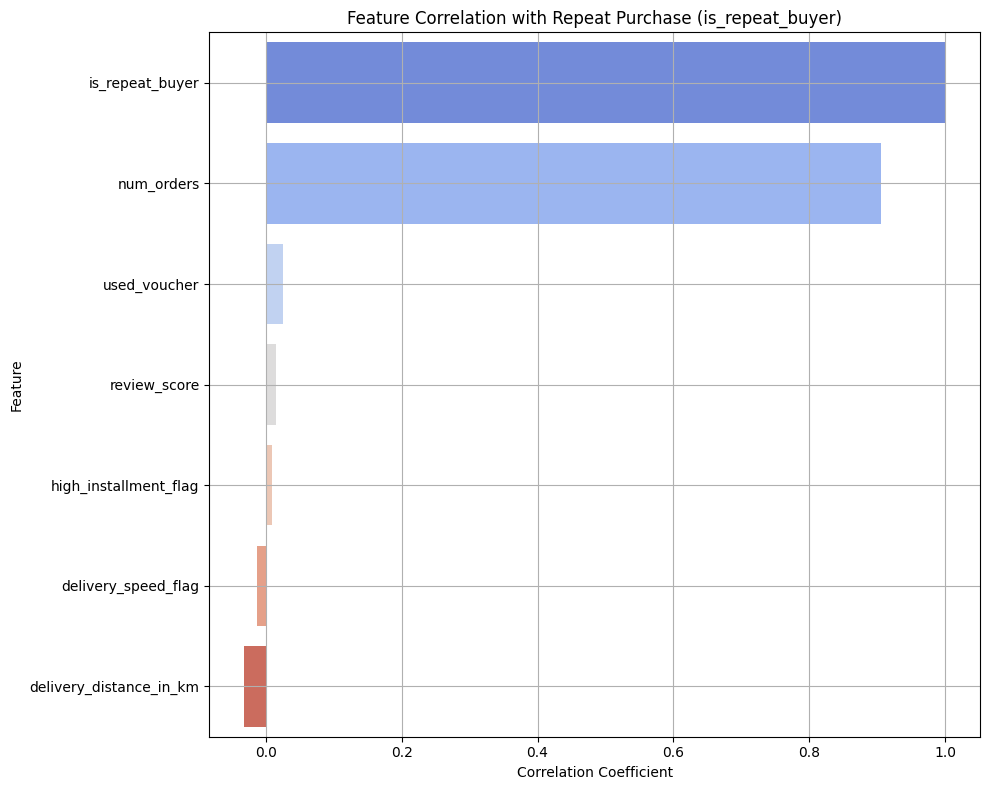

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_columns = [
    'delivery_speed_flag', 'delivery_distance_in_km', 'high_installment_flag',
    'used_voucher', 'is_repeat_buyer', 'num_orders', 'review_score'
]

# Filter down the columns
final_df_small = final_df.select(*selected_columns)

# Convert to Pandas
final_pdf = final_df_small.toPandas()

# Calculate correlation matrix
corr_matrix = final_pdf.corr(numeric_only=True)

# Focused heatmap: correlation with target
target_corr = corr_matrix["is_repeat_buyer"].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Feature Correlation with Repeat Purchase (is_repeat_buyer)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()


## LR

In [95]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.functions import vector_to_array

# === 1. Define your features ===
raw_feature_cols = [
    "delivered_in_days",
    "time_of_purchase",
    "month_of_purchase",
    "delivery_speed_flag",
    "delivery_distance_in_km",
    "installment_value",
    "high_installment_flag",
    "used_voucher",
    "num_orders",
    "total_purchase_value",
    "review_score"
]

# === 2. Explode OneHotEncoded category column (category_grouped_ohe) ===
df = final_df.withColumn("ohe_array", vector_to_array("category_grouped_ohe"))
num_dims = len(df.select("ohe_array").first()[0])

# Create individual category columns
for i in range(num_dims):
    df = df.withColumn(f"category_ohe_{i}", col("ohe_array")[i])

# Create full feature list (numeric + exploded OHE features)
ohe_feature_cols = [f"category_ohe_{i}" for i in range(num_dims)]
feature_cols = raw_feature_cols + ohe_feature_cols

# === 3. Cast all feature columns to double and fill nulls ===
for c in feature_cols:
    df = df.withColumn(c, col(c).cast("double"))

df = df.fillna(0, subset=feature_cols)

# === 4. Assemble features into a single vector ===
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", "is_repeat_buyer")

# === 5. Fit logistic regression model ===
lr = LogisticRegression(featuresCol="features", labelCol="is_repeat_buyer")
lr_model = lr.fit(assembled_df)

# === 6. Summary ===
training_summary = lr_model.summary
print("Accuracy:", training_summary.accuracy)
print("Area Under ROC:", training_summary.areaUnderROC)
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Accuracy: 1.0
Area Under ROC: 0.9999994027840805
Coefficients: [0.001490725937255467,-0.0014891495111402048,-0.012482389281153165,0.009297068471545747,-1.7525717728532046e-05,-0.00043740612440832874,-0.03931449352519794,0.17257572600357682,36.133619063294816,0.00037148108433288177,0.012285189218801753,-0.038435106314282985,0.1522345400673385,-0.10628728951411934,0.05027903868872832,0.15675889799146883,0.040295657178202215,-0.04269653364888824,-0.07819245606044149,-0.09164037313137793,0.04173385286186637,-0.12847320027111955,-0.09199158101658929,-0.1143789119822196,-0.061110248378340046,-0.054213173667400555,-0.06766891856394625,-0.009741457488927524,-0.5995857693827245]
Intercept: -54.79387961007609


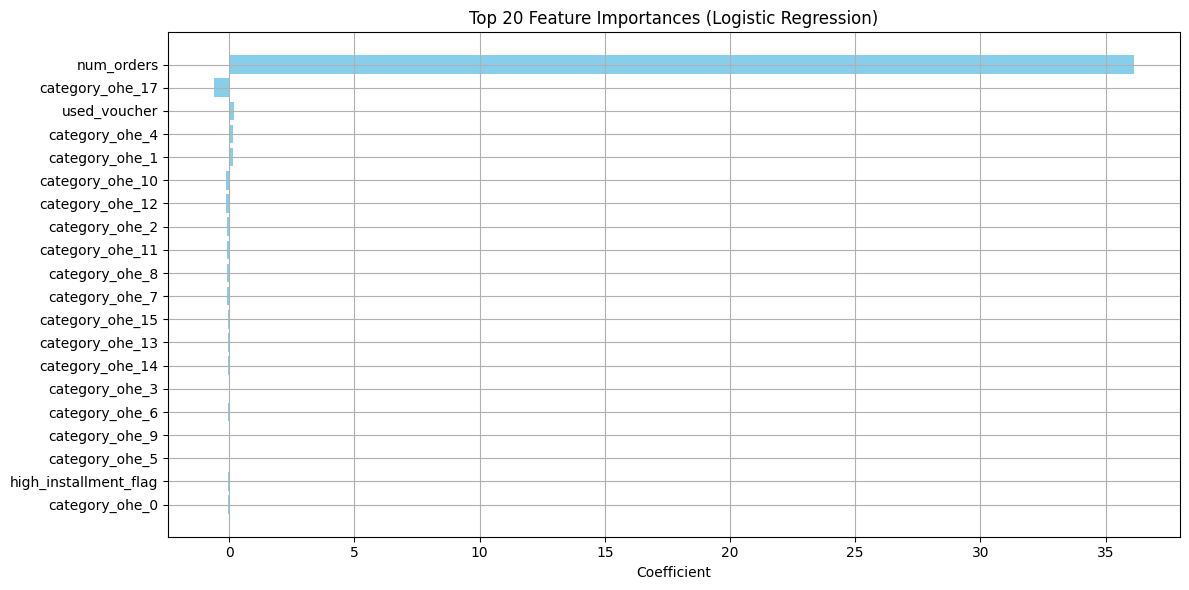

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Combine raw feature names and one-hot encoded category names
all_features = raw_feature_cols + ohe_feature_cols

# Convert coefficients to NumPy array
coefficients = np.array(lr_model.coefficients.toArray())

# Create a DataFrame for plotting
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})

# Get top 20 features by absolute coefficient magnitude
top_coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_coef_df["feature"], top_coef_df["coefficient"], color='skyblue')
plt.xlabel("Coefficient")
plt.title("Top 20 Feature Importances (Logistic Regression)")
plt.gca().invert_yaxis()  # highest at top
plt.grid(True)
plt.tight_layout()
plt.show()


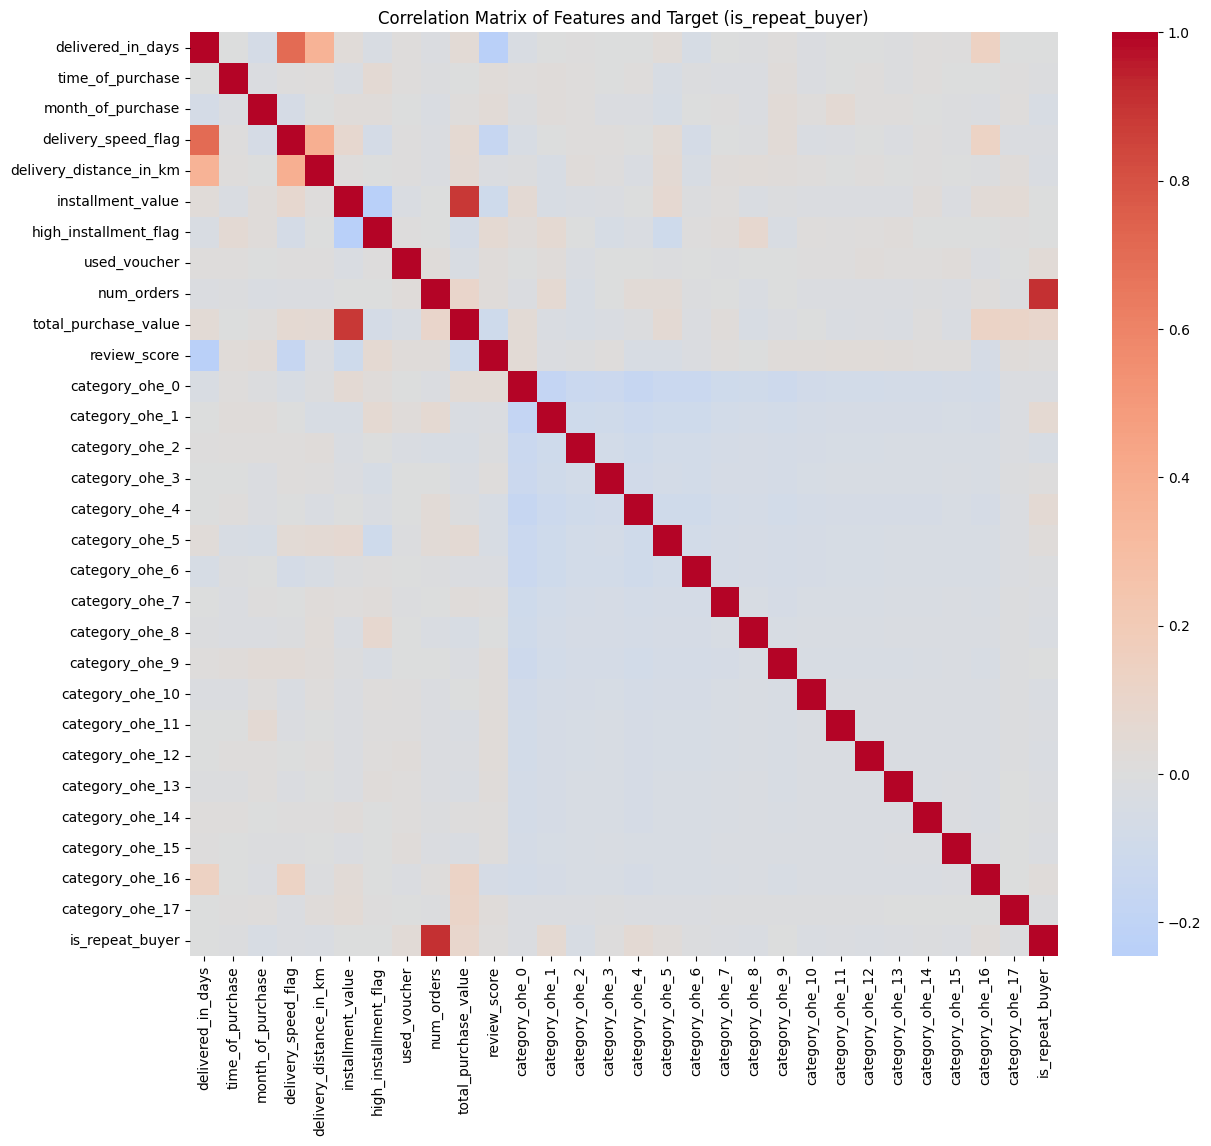

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Convert feature vector to array columns (if not done yet)
df_features = assembled_df.withColumn("features_array", vector_to_array("features"))

# Select feature array and label
df_features = df_features.select("features_array", "is_repeat_buyer")

# Convert to Pandas
pandas_df = df_features.toPandas()

# Expand feature array to separate columns
features_expanded = pd.DataFrame(pandas_df["features_array"].tolist(), columns=all_features)

# Combine with label
pandas_full = pd.concat([features_expanded, pandas_df["is_repeat_buyer"]], axis=1)

# Compute correlation matrix
corr_matrix = pandas_full.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features and Target (is_repeat_buyer)")
plt.show()
